Simulation 10000/10000 (s=0.800)        
Simulation 10000/10000 (s=0.807)        
Simulation 10000/10000 (s=0.813)        
Simulation 10000/10000 (s=0.820)        
Simulation 10000/10000 (s=0.827)        
Simulation 10000/10000 (s=0.834)        
Simulation 10000/10000 (s=0.841)        
Simulation 10000/10000 (s=0.848)        
Simulation 10000/10000 (s=0.855)        
Simulation 10000/10000 (s=0.862)        
Simulation 10000/10000 (s=0.869)        
Simulation 10000/10000 (s=0.876)        
Simulation 10000/10000 (s=0.884)        
Simulation 10000/10000 (s=0.891)        
Simulation 10000/10000 (s=0.898)        
Simulation 10000/10000 (s=0.906)        
Simulation 10000/10000 (s=0.913)        
Simulation 10000/10000 (s=0.921)        
Simulation 10000/10000 (s=0.928)        
Simulation 10000/10000 (s=0.936)        
Simulation 10000/10000 (s=0.944)        
Simulation 10000/10000 (s=0.952)        
Simulation 10000/10000 (s=0.960)        
Simulation 10000/10000 (s=0.968)        
Simulation 10000

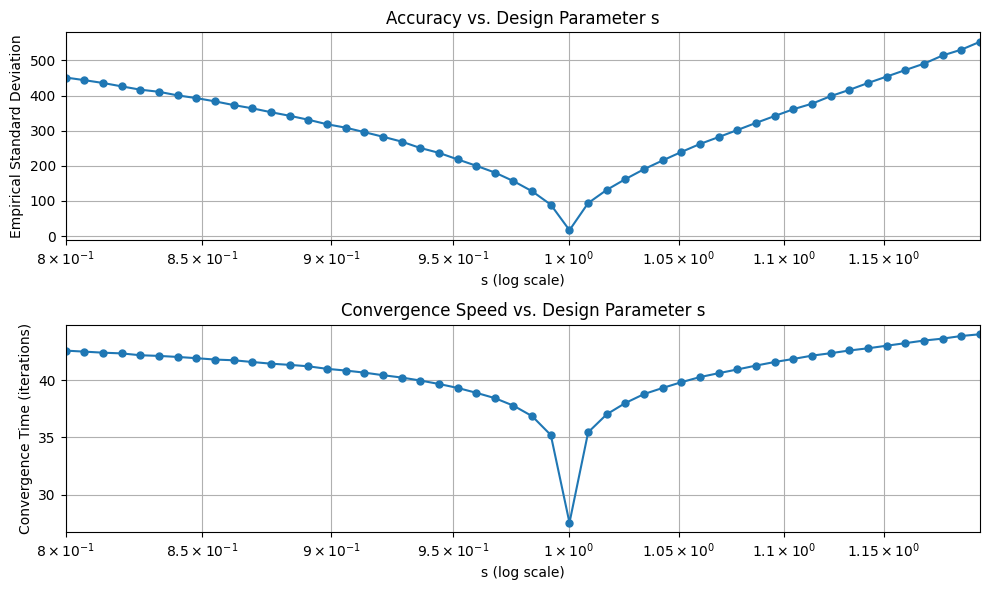

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# 固定随机种子以确保可重复性
# np.random.seed(42)

n = 200  # 代理数量
p = 0.1  # 边生成概率
threshold = 1e-2  # 收敛阈值
max_iterations = 1000  # 最大迭代次数
num_simulations = 10000  # 每个s值的模拟次数
delta = 1  # 差分隐私参数
epsilon = 0.1  # 隐私预算
alpha = 1e-6  # 噪声衰减参数

# 生成I矩阵，单位矩阵
A = np.zeros((n, n))

# 设置边权重为两个伯努利试验的和
for i in range(n):
    for j in range(i+1, n):
        w = np.random.binomial(1, 0.1) + np.random.binomial(1, 0.1)
        A[i, j] = w
        A[j, i] = w

D = np.diag(A.sum(axis=1))  # 度数矩阵
L = D - A  # 拉普拉斯矩阵
d_max = D.max().item()  # 最大度数
h = 0.99 / d_max  # 步长满足稳定性条件
# h = np.random.uniform(0.01, 0.99)
# h /= d_max

# 初始化代理状态（固定种子）
theta0 = np.random.normal(50, 10, n)

def simulate_s(s):
    # np.random.seed()  # 进程独立随机种子
    q = alpha + (1 - alpha) * abs(s - 1)
    c = delta * q / (epsilon * (q - abs(s - 1)))
    S = s * np.eye(n)
    B = S - h * L
    A_matrix = np.eye(n) - h * L  # 状态转移矩阵

    theta_infinites = []
    convergence_times = []

    for _ in range(num_simulations):
        if (_+1) % 10 == 0:
            print(f"Simulation {_+1:03d}/{num_simulations} (s={s:.3f})".ljust(40), 
              end='\r', 
              flush=True)
        theta = theta0.copy()
        converged = False
        for k in range(max_iterations):
            b = c * q ** k
            eta = np.random.laplace(scale=b, size=n)
            next_theta = A_matrix @ theta + B @ eta
            thres_hold = max(threshold, b*0.1)
            if np.linalg.norm(next_theta - theta) < thres_hold:
                converged = True
                break
            theta = next_theta.copy()
        convergence_times.append(k if converged else max_iterations)
        theta_avg = np.mean(theta)
        theta_infinites.append(theta_avg)
    
    print()

    variance = np.std(theta_infinites)
    avg_time = np.mean(convergence_times)
    return variance, avg_time

s_values = np.logspace(np.log10(0.8), np.log10(1.2), num=50)
# s_values = np.linspace(np.log10(0.8), np.log10(1.2), num=100)
# s_values = np.linspace(0.8, 1.2, num=100)

# 单核计算
variances = []
times = []
for s in s_values:
    variance, avg_time = simulate_s(s)
    variances.append(variance)
    times.append(avg_time)
variances = np.sqrt(variances)

# 画在一张图中
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogx(s_values, variances, 'o-', markersize=5)
plt.xlabel('s (log scale)')
plt.ylabel('Empirical Standard Deviation')
# y轴范围是0-1.5*10e6，0.5为间隔设置y轴
plt.xlim(0.8, 1.2)
plt.xticks(np.arange(0.8, 1.2, 0.05))
plt.title('Accuracy vs. Design Parameter s')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(s_values, times, 'o-', markersize=5)
plt.xlabel('s (log scale)')
plt.ylabel('Convergence Time (iterations)')
plt.xlim(0.8, 1.2)
plt.xticks(np.arange(0.8, 1.2, 0.05))
plt.title('Convergence Speed vs. Design Parameter s')
plt.grid(True)
plt.tight_layout()

plt.show()
